In [165]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import scipy.linalg as la
import math
from numpy import random
import cmath
import time

### Hamiltonian Generation

In [2]:
epsilon = 0.01
X = np.array([[0, 1],
     [1, 0]])
Z = np.array([[1, 0],
     [0, -1]])
I = np.array([[1, 0],
     [0, 1]])
XX = np.kron(X, X) #tensor products between two Pauli's
XZ = np.kron(X, Z)
ZZ = np.kron(Z, Z)
ZX = np.kron(Z, X)
II = np.kron(I, I)

In [3]:
#List of Hamiltonian decomposition terms H_j for H = \sum_j h_j H_j
Hlist = np.array([XX, XZ, ZX, ZZ])
hj = [1.0, 2.0, 3.0, 4.0] #list of normalized coefficients
lambd = sum(hj)
#t = 10
gamma = 2
alphacomm = 4 * lambd**3
#r = int(((t**3)* 4 * (gamma**4))/(epsilon * 3)) #omitted alphacomm might be prohibitive

L = 4 #number of terms in the Hamiltonian
InitialState = [1/(2**(1/2)), 0, 1/(2**(1/2)), 0]
print(Hlist.shape)
print(r)

(4, 4, 4)
2133333


### Trotter-Suzuki Second Order Simulation

In [195]:
def S2Trotter(Hlist, t, r): #Creates a list of all of the evolution operators in 2nd order Trotter-Suzuki
    U = []
    for i in range(0, 4):
        U.append((math.cos(t*hj[i]/(2*r)))*(Hlist[i, :, :]) - 1j*math.sin(t*hj[i]/(2*r))*II)
    for i in range(1, 5): 
        U.append((math.cos(t*hj[-i]/(2*r)))*(Hlist[-i, :, :]) - 1j*math.sin(t*hj[-i]/(2*r))*II)
    return U #Takes in Hamiltonian terms and converts them each into evolution operators

In [5]:
S2 = S2Trotter(Hlist) #A list of all of the evolution operators in 2nd order Trotter-Suzuki
#dim = len(S2)
def EvolveStore(S2): #Applies each of the evolution operators storing the previous state in a matrix row
    Psi = np.zeros((r*dim + 1, 4), dtype = complex)
    Psi[0, :] = InitialState
    for i in range(dim*r):
        Psi[i+1, :] = S2[i%8] @ Psi[i, :] # %8 is because one application of S2 trotter has 8 ops when N=4
    return Psi

In [205]:
def S2_Comp(OperatorCoeffs, OperatorList, t, r, TrueState): #Applies each of the evolution operators storing the previous state in a matrix row
    TrotterOps = S2Trotter(Hlist, t, r)
    infidelity = 0
    dim = len(TrotterOps)
    Psi = np.zeros((4), dtype = complex)
    Psi = InitialState
    for i in range(dim*r):
        Psi = S2[i%8] @ Psi # %8 is because one application of S2 trotter has 8 ops when N=4
        if i % 8 == 1:
            infidelity = sum((np.abs(TrueState - Psi))**2)
    return infidelity

In [288]:
A = EvolveStore(S2)

sum(np.abs(A[48, :])**2) #checks normalization at any point in time (as in after a certain number of gates).


1.000000000000003

In [20]:
l = [1, 2, 3, 4]
print(l[4%4])
print(range(0,9))

1
range(0, 9)


In [267]:
i = 0
for i in range(4):
    i+=1
print(i)

4


### QDRIFT Simulator

In [138]:
x=random.rand()
print(x)

0.3283521118012781


In [167]:
lambd = sum(hj)
#N = int(2*(lambd**2)*(t**2)/epsilon)
#tau = t*lambd/N
def QdriftPool(Hlist,t, N):
    tau = t*lambd/N
    U = []
    for i in range(0, 4):
        U.append((math.cos(tau))*(Hlist[i, :, :]) - 1j*math.sin(tau)*II)
    return U

def SumRange(hj, m, n):
    #list of terms hj, m, n the min and max of the sum range
    l = 0
    for i in range(m, n):
          l += hj[i]
    return l

In [157]:
DriftOps = QdriftPool(Hlist) #requires that hj be ordered least to greatest at the moment 
def QDRIFTstoring(Hlist, hj): # also does not work if 2 terms are the same size 
    Psi = np.zeros((N + 1, 4), dtype = complex)
    Psi[0, :] = InitialState
    for i in range(0, N):
        x = random.rand() 
        for j in range(L):
            if SumRange(hj, 0, j)/lambd < x <= SumRange(hj, 0, j+1)/lambd: #fix this with sums
                   Psi[i+1, :] = DriftOps[j+1] @ Psi[i]
            
            elif (sum(hj) - hj[3])/lambd < x <=1:
                Psi[i+1, :] = DriftOps[3] @ Psi[i]
            
            elif 0 < x <=hj[0]/lambd:
                Psi[i+1, :] = DriftOps[0] @ Psi[i] #elif statements are written knowing max and min of hj
            
            else:
                pass
    return Psi #not working correctly see below

TypeError: QdriftPool() missing 2 required positional arguments: 't' and 'N'

In [178]:
def QDRIFT_comp(OperatorCoeffs, OperatorBin, N, t, TrueState): #same as the above function but does not store intermediate states
    Psi = np.zeros((4), dtype = complex)
    DriftOps = QdriftPool(Hlist, t, N)
    Psi = InitialState
    fidelity = 0
    for i in range(0, N):
        x = random.rand() 
        for j in range(L):
            if SumRange(hj, 0, j)/lambd < x <= SumRange(hj, 0, j+1)/lambd: #fix this with sums
                   Psi = DriftOps[j] @ Psi
            
            #elif (sum(hj) - hj[3])/lambd < x <=1:
                #Psi = DriftOps[3] @ Psi
            
            #elif 0 < x <=hj[0]/lambd:
                #Psi = DriftOps[0] @ Psi #elif statements are written knowing max and min of hj
            
            #else:
                #pass
        
        fidelity += (np.abs(TrueState @ np.conjugate(Psi)))**2
        
    infidelity = 1 - ((1/N) * fidelity)
    
    return infidelity

In [25]:
B = QDRIFTstoring(Hlist, hj)
#C = QDRIFT(Hlist)

### Plotting Comparisons

[0.28247699 0.15275564 0.34228721 0.22248016]
1.000000000000004


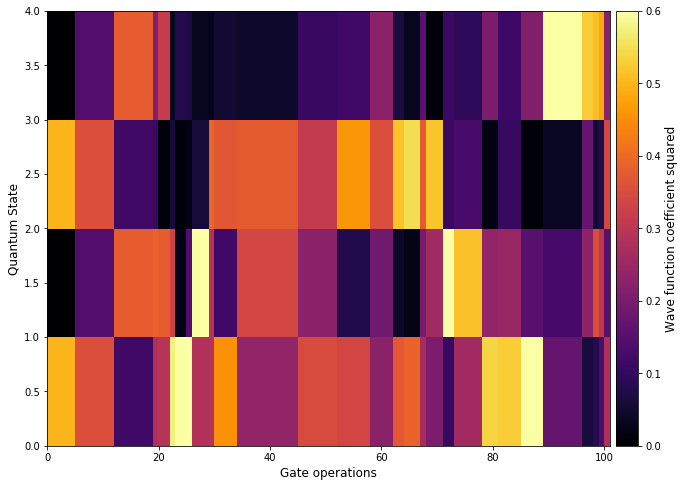

In [26]:
#QDRIFT plot
B2 = np.abs(B)**2
plt.figure(figsize = (12,8))
plt.ylim(0,4) #limits the range the plot shows
plt.xlabel('Gate operations', size = 12)
plt.ylabel('Quantum State', size = 12)
plt.imshow(np.transpose(B2), origin = 'bottom left', aspect = 'auto', 
           cmap = 'inferno', vmax = 0.6, interpolation = 'none', extent = [0, N+1, 0, 4]) 
# vmax alters the sensitivity of the colour plot, so increase for large particle numbers
cbar = plt.colorbar(pad = 0.01) #pad chooses the distance of the colour bar from the plot
cbar.set_label('Wave function coefficient squared',size=12) 
print(B2[N, :]) #final state
print(sum(B2[N, :])) #norm of final state

[4.99999990e-01 1.58203173e-09 5.00000002e-01 6.32812693e-09]


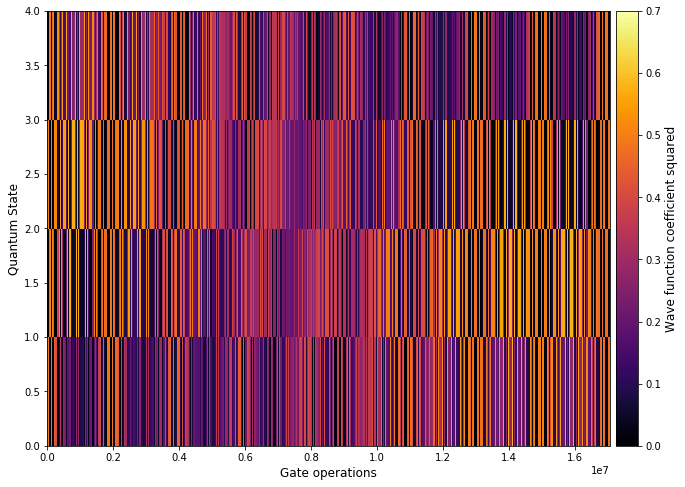

In [289]:
#Trotter plot
A2 = np.abs(A)**2
plt.figure(figsize = (12,8))
plt.ylim(0,4) #limits the range the plot shows
plt.xlabel('Gate operations', size = 12)
plt.ylabel('Quantum State', size = 12)
plt.imshow(np.transpose(A2), origin = 'bottom left', aspect = 'auto', 
           cmap = 'inferno', vmax = 0.7, interpolation = 'none', extent = [0, dim*r+1, 0, 4]) 
# vmax alters the sensitivity of the colour plot, so increase for large particle numbers
cbar = plt.colorbar(pad = 0.01) #pad chooses the distance of the colour bar from the plot
cbar.set_label('Wave function coefficient squared',size=12) 
print(A2[48, :]) #final state

### Solution by exact diagonalization

In [175]:
def HamiltonianMat(Hlist, hj): #just makes one hamiltonian matrix based on the lists
    U = []
    for i in range (0, L):
        U.append(hj[i]*Hlist[i, :, :])
    H = sum(U)
    return H

In [176]:
H = HamiltonianMat(Hlist, hj)
(Y,V) = la.eigh(H) #Diagonalizes the hamiltonian
print(Y)
#This calculates the eigen vectors V and the eigenvalues Y of the Hamiltonian. Note: the eigenvalues are ordered.

[-5.83095189 -5.09901951  5.09901951  5.83095189]


In [177]:
V_i = np.array(V, dtype = complex)
Psi_t = (V_i) @ np.diag(np.exp(-1j*Y*t)) @ np.conjugate(V_i.T) @ InitialState #evolves the system by applying U directly
print(Psi_t)

[ 0.47465007-0.01283905j  0.14578739-0.31012107j  0.47465007+0.42646607j
 -0.14578739-0.47821905j]


In [74]:
print("Exact solution: ", np.abs(Psi_t ** 2))
#print("QDRIFT solution: ", B2[N, :])
#print("2nd Order Trotter Solution: ", A2[r*dim, :])
print(QDRIFT_comp(hj, Hlist, 100, 2, Psi_t))

Exact solution:  [0.53085473 0.24862063 0.19552207 0.02500258]
0.1365887681925041


### QDRIFT Performance

In [187]:
startTime = time.time()

tStart = 1
tFinal = 15
tSteps = 20
times = np.linspace(tStart, tFinal, tSteps)
#print(time)
N = int(2*(lambd**2)*(tfinal**2)/epsilon)
infidel_t = []
for t in times:
    #N = int(2*(lambd**2)*(tfinal**2)/epsilon)
    infidel = QDRIFT_comp(hj, Hlist, N, t, Psi_t)
    infidel_t.append(infidel)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

Execution time in seconds: 465.60225105285645


[0.750006868554248, 0.7500002093937443, 0.7500347607513467, 0.7500952043195986, 0.7500682571674506, 0.7500757492521395, 0.7500303013947417, 0.7498878610102905, 0.7501556987387857, 0.7498536387877064, 0.7500509491849162, 0.7501826632122064, 0.7501951519723893, 0.7501269045048801, 0.7499161728071946, 0.7503004328440182, 0.7500346311705506, 0.7497422807633756, 0.7500162094262595, 0.7500157124608615]


Text(0, 0.5, 'log(infidelity)')

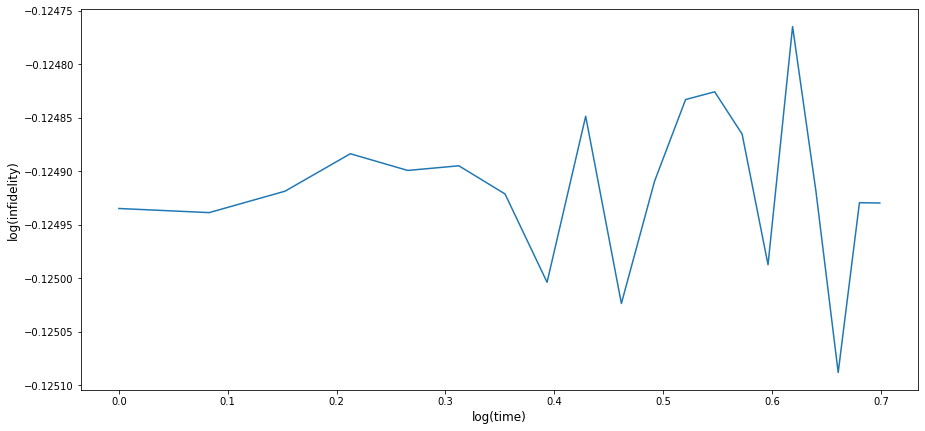

In [210]:
print(infidel_t)
log_infidelity = np.log10(infidel_t)
log_time = np.log10(times)

plt.figure (figsize = (15, 7))
plt.plot(log_time, log_infidelity) #Remove the squared to simply see the wavefunction
plt.xlabel('log(time)', size = 12)
plt.ylabel('log(infidelity)', size = 12)
#plt.xlim(-25, 25) #Set limit on the x-axis. Comment this out if you wish to study the entire plot

### Trotter S2 Performance

In [215]:
startTime = time.time()

tStart = 1
tFinal = 10
tSteps = 100
times = np.linspace(tStart, tFinal, tSteps)
#print(time)
#r = int(((t**3)* 4 * (gamma**4))/(epsilon * 3)) #omitted alphacomm might be prohibitive
Trot_infidel_t = []
for t in times:
    r = int(((t**3)* 4 * (gamma**4))/(epsilon * 3))
    Trot_infidel = S2_Comp(hj, Hlist, t, r, Psi_t)
    Trot_infidel_t.append(Trot_infidel)

executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

Execution time in seconds: 1080.7816631793976


[1.9926880898788513, 1.990513753655574, 1.9879486837374927, 1.9849673801879684, 1.9815474296679982, 1.9776641465132865, 1.9733092235572502, 1.9684729070720905, 1.9631636185843844, 1.9574015973452599, 1.9512296151305568, 1.9447117176769622, 1.9379423292041376, 1.931055217212619, 1.924226887299915, 1.9176791084844345, 1.9116929140187806, 1.9066143037974963, 1.9028436946853824, 1.9008469620369, 1.901141566110604, 1.9042802856539631, 1.9108279952531477, 1.9213148128436182, 1.9361950198590359, 1.9557612868871117, 1.9800716497362678, 2.008852685398905, 2.0413728172056933, 2.0763819820088525, 2.111993841115652, 2.1456825981883565, 2.1742964939176774, 2.1942070361735064, 2.2015799797545745, 2.1927909305347537, 2.1650012101814604, 2.1168741232506676, 2.0493225699822766, 1.9662302326727779, 1.8749040086854358, 1.7860889447838906, 1.7133020312499934, 1.6712464715901332, 1.673371931522188, 1.7286027582021697, 1.8378093778917723, 1.9908102952191329, 2.165005214969003, 2.3268059528313207, 2.43680232

Text(0, 0.5, 'log(infidelity)')

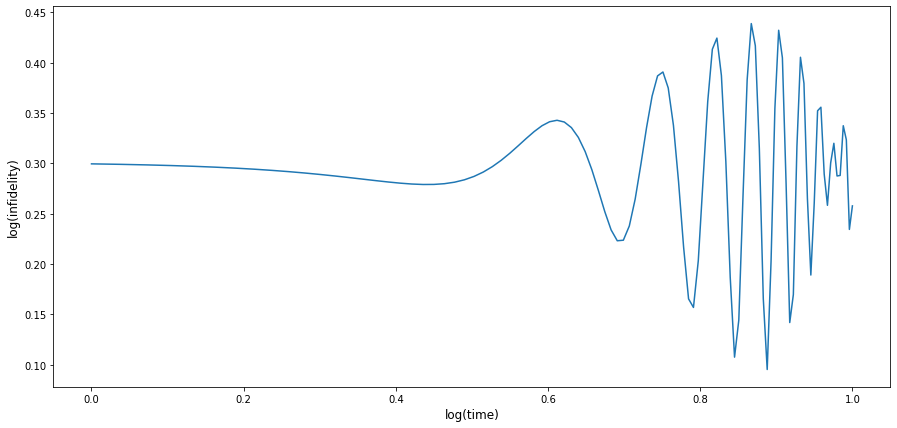

In [220]:
print(Trot_infidel_t)
Trot_log_infidelity = np.log10(Trot_infidel_t)
Trot_log_time = np.log10(times)

plt.figure (figsize = (15, 7))
plt.plot(Trot_log_time, Trot_log_infidelity) #Remove the squared to simply see the wavefunction
plt.xlabel('log(time)', size = 12)
plt.ylabel('log(infidelity)', size = 12)
#plt.xlim(-25, 25) #Set limit on the x-axis. Comment this out if you wish to study the entire plot